## Let's count the total successful diffs by each tool

In [4]:
import os

# Define the base directory path
base_dir = '../results/contracts/mutants/'

# Initialize counters
diff_result_GT_count = 0
diff_result_difft_count = 0

# Traverse the directory hierarchy
for root, dirs, files in os.walk(base_dir):
    # Count the specific json files
    diff_result_GT_count += files.count('diff_result_GT.json')
    diff_result_difft_count += files.count('diff_result_difft.json')

diff_result_GT_count, diff_result_difft_count


(339596, 336331)

In [5]:
import pickle
import pprint
import csv
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np


def load_pickles(file1, file2):
    difft_file = open(file1, "rb")
    gt_file = open(file2, "rb")

    difft = pickle.load(difft_file)
    GT = pickle.load(gt_file)

    return {"GT": GT, "difft": difft}


def setup(n_mut):
    res = [0] * n_mut
    count = [0] * n_mut
    mut_res = {}
    mut_count = {}

    return {"res": res, "count": count, "mut_res": mut_res, "mut_count": mut_count}


def remove_mut_operators(diff_results, operators):
    for diff_tool in diff_results:
        for contract in diff_results[diff_tool]:
            for i in range(len(diff_results[diff_tool][contract])):
                for r in operators:
                    if r in diff_results[diff_tool][contract][i].keys():
                        diff_results[diff_tool][contract][i].pop(r)


def analyze_diffs(diffs, res_dict, n_mut):
    is_GT = isinstance(next(iter(next(iter(diffs.values()))[0].values())), list)

    for contract in diffs:
        for i in range(len(diffs[contract])):
            for mut in diffs[contract][i]:
                if not diffs[contract][i][mut] == []:
                    res_dict["count"][i] += 1
                    if is_GT:
                        res_dict["res"][i] += diffs[contract][i][mut][0]
                    else:
                        res_dict["res"][i] += diffs[contract][i][mut]
                    
                    if not mut in res_dict["mut_res"].keys():
                        res_dict["mut_res"][mut] = [0] * n_mut
                        res_dict["mut_count"][mut] = [0] * n_mut 

                    if is_GT:
                        res_dict["mut_res"][mut][i] += diffs[contract][i][mut][0]
                    else:
                        res_dict["mut_res"][mut][i] += diffs[contract][i][mut] 
                    res_dict["mut_count"][mut][i] += 1    

    #Calculate average results 
    res_dict["res"] = [i / j for i, j in zip( res_dict["res"],  res_dict["count"])]

    for mut in res_dict["mut_res"]:
        for i in range(len(np.trim_zeros( res_dict["mut_res"][mut]))):
            res_dict["mut_res"][mut] = np.trim_zeros( res_dict["mut_res"][mut])
            res_dict["mut_count"][mut] = np.trim_zeros( res_dict["mut_count"][mut])
            res_dict["mut_res"][mut][i] /= res_dict["mut_count"][mut][i]


def print_summary(GT, difft):
    print("====================================")
    print("difftastic average: " + str(difft["res"]))
    print("successful # of mutations: ", difft["count"])
    print("Gumtree average: " + str(GT["res"]))
    print("successful # of mutations: ", GT["count"])
    print("====================================")


    plt.bar(x = [1,2,3,4,5,6,7,8,9,10], height = difft["count"], color = 'b')
    plt.xticks([1,2,3,4,5,6,7,8,9,10])
    plt.title("Number of Times X Amount of Mutations Could be Applied to Files")
    plt.xlabel("Number of Mutations")
    plt.ylabel("Successful Mutations")
    plt.show()


def print_by_mutation(res_dict):
    
    print("EDIT SCRIPT LENGTH BY MUTATION:")
    print("=====================================================")
    mut_sorted = sorted(res_dict["mut_res"].items(), key = lambda x: x[1][len(x[1])-1])
    for mut in mut_sorted:
        print(mut[0], mut[1], " counts:", res_dict["mut_res"][mut[0]])
    print("=====================================================")


def save_as_csv(filename):
    with open(filename, 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter= " ", quotechar='|')
        for key in GT_res_dict["mut_res"]:
            writer.writerow([key] + GT_res_dict["mut_res"][key])
        writer.writerow("           ")
        for key in difft_res_dict["mut_res"]:
            writer.writerow([key] + difft_res_dict["mut_res"][key])


def scatter_with_avg_plot(GT, difft):
    plt.plot(range(10) ,difft["res"], label=("difft_avg"), color="blue")
    for mut in difft["mut_res"]:
        x = [i+0.985 for i in range(len(difft["mut_res"][mut]))]
        plt.scatter(x, difft["mut_res"][mut], color="blue", s=6)

    plt.plot(range(10), GT["res"], label ="GT_avg", color = "red")
    for mut in GT["mut_res"]:
        x = [i+1.015 for i in range(len(GT["mut_res"][mut]))]
        plt.scatter(x, GT["mut_res"][mut], color="red", s=6)

    plt.title("Average Edit Distance per Mutation and Tool")
    plt.ylabel("edit actions")
    plt.xlabel("# of mutations")
    plt.minorticks_on()
    plt.xticks(range(11))
    plt.legend()
    plt.show()


def box_plot(data, offset):
    box(data[0], offset, "green")
    box(data[1], -offset, "blue")

    green_patch = mpatches.Patch(color="green", label="Gumtree")
    blue_patch = mpatches.Patch(color="blue", label="difftastic")
    plt.legend(handles=[green_patch, blue_patch])

    x = [1,2,3,4,5,6,7,8,9,10]
    plt.ylabel("edit actions")
    plt.xlabel("# of mutations")
    plt.xticks(x, labels=x)
    plt.title("Edit Distances")
    plt.show()


def box(data, offset, color):
    d = [[] for _ in range(10)]
    for key in data.keys():
        for i in range(len(data[key])):
            d[i].append(data[key][i])
    
    x = [x - offset for x in [1,2,3,4,5,6,7,8,9,10]]
   
    plt.boxplot(d, widths=0.27, patch_artist=True,
        positions=x,
        showmeans=True, showfliers=False,
        medianprops={"color": "white", "linewidth": 1},
        boxprops={"facecolor":  color, "edgecolor": "black",
                  "linewidth": 0.25},
        whiskerprops={"color": color, "linewidth": 1},
        meanprops={"markerfacecolor": color, "markeredgecolor": "black"},
        capprops={"color": color, "linewidth": 1})


def bar_by_mut_plot(data, offset, oper, title):
    
    fig, ax = plt.subplots(layout='constrained')

    bar(data[0], -offset, "green", ax, oper)
    bar(data[1], offset, "blue", ax, oper)
    ax.tick_params(labelsize=7)

    red_patch = mpatches.Patch(color="lime", label="Gumtree")
    blue_patch = mpatches.Patch(color="b", label="difftastic")
    plt.legend(handles=[red_patch, blue_patch], fontsize=14)
    
    plt.xlabel("Mutation Operator", fontsize=16)
    plt.ylabel("Edit Distance", fontsize=16)
    plt.title(title, fontsize=20)
    plt.show()


def bar(data, offset, color, subplot, oper):  
    #greens = ["darkgreen", "green", "forestgreen", "seagreen", "lime", "lawngreen", "lightgreen", "chartreuse", "greenyellow", "springgreen"]
    greens = ['#173d00','#225009','#2e6413','#3a781e','#478d29','#53a334','#60b940','#6cd04c','#79e759','#85ff66']
    greens.reverse()
    #blues= ["navy", "midnightblue", "darkblue", "mediumblue", "blue","royalblue",  "deepskyblue", "turquoise","cyan", "paleturquoise"]
    blues = ['#140052','#071f70','#003b8b','#0056a2','#0071b6','#008dca','#00aada','#0bc6e8','#4ae3f4','#75ffff']
    blues.reverse()

    colors = "none"
    if color == "blue":
        colors = blues
    elif color == "green":
        colors = greens

    x = np.arange(len(oper))
    n = 0
    for key in oper:
        plt_data = np.around(data[key], 2)
        for i in range(len(plt_data)-1, -1, -1):
            subplot.bar(x = x[n] + offset, width =  0.25, height = plt_data[i], color = colors[i])
        n += 1
    subplot.set_xticks(x, oper)
    

def calc_corr(data):
    x = [1,2,3,4,5,6,7,8,9,10]
    count = [0 for _ in range(10)]
    
    d = [0 for _ in range(10)]
    for key in data.keys():
        for i in range(len(data[key])):
            d[i] += data[key][i]
            count[i] += 1
    
    res = [i / j for i, j in zip(d, count)]

    r = np.corrcoef(x, res)
    r2 = np.polyfit(x, res, 1)
    print("Slope: ", r2, "\nCorrelation:", r, '\n')        


def find_most_mut(diffs):
    res = []
    for contract in diffs:
        n_keys = len(diffs[contract][0].keys())
        if n_keys > 29:
            res.append((contract, n_keys))
    return res


def main_analysis():
    num_mut = 10
    pickles = load_pickles("results-difft.pickle", "results-GT.pickle")

    remove_mut_operators(pickles, ["AVR","SCEC"])
    #print(find_most_mut(pickles["GT"]))

    GT_res_dict = setup(num_mut)
    analyze_diffs(pickles["GT"], GT_res_dict, num_mut)
   
    difft_res_dict = setup(num_mut)
    analyze_diffs(pickles["difft"], difft_res_dict, num_mut)

    #print_summary(GT_res_dict, difft_res_dict)
    #print_by_mutation(difft_res_dict)
    #print_by_mutation(GT_res_dict)

    #scatter_with_avg_plot(GT_res_dict, difft_res_dict)
    box_plot((GT_res_dict["mut_res"], difft_res_dict["mut_res"]), 0.15)
   

    #x = [1,2,3,4,5,6,7,8,9,10]
    #r = np.corrcoef(x, GT_res_dict["res"])
    #r2 = np.polyfit(x, GT_res_dict["res"], 1)
    #print("Gumtree slope: ", r2, "\nGumtree correlation:", r, '\n')
    #calc_corr( GT_res_dict["mut_res"])

    
    #r = np.corrcoef(x, difft_res_dict["res"])
    #r2 = np.polyfit(x, difft_res_dict["res"], 1)
    #print("difft slope: ", r2, "\ndifft correlation:", r)
    #calc_corr( difft_res_dict["mut_res"])
   
    

    # removed operators due to errors in testing: "AVR",  "SCEC"
    opers = []
    opers.append( ["BLR", "HLR", "ILR", "SLR"])
    opers.append( ["AOR", "BOR", "DOD", "ECS", "ICM", "MCR", "UORD","VUR"])
    opers.append( ["CBD", "CCD", "CSC", "EED", "EHC", "OLFD", "ORFD", "RSD"])
    opers.append( ["ACM", "LSC", "MOC", "MOD", "MOI", "MOR", "RVS"])
    opers.append( ["BCRD","DLR","ER","ETR","FVR","GVR","PKD","SFR","SKD","SKI","TOR","VVR"])
    titles = ["Mutated Literals", "Mutated Operators & Type Specifications", "Mutated Code Blocks", "Mutated Arguments & Modifers", "Other Mutations"]

    for i in range(len(opers)):
        print((GT_res_dict["mut_res"], difft_res_dict["mut_res"]), '\n', opers[i], '\n')
        bar_by_mut_plot((GT_res_dict["mut_res"], difft_res_dict["mut_res"]), 0.15, opers[i], titles[i])


def sample_analysis():
    num_mut = 1
    pickles = load_pickles("test-results-difft.pickle", "test-results-GT.pickle")
    
    remove_mut_operators(pickles, ["AVR","SCEC"])

    
    res = ({}, {})
    for key in pickles["GT"].keys():
        res[0][key] = [pickles["GT"][key][0]["mut"][0]]
        res[1][key] = [pickles["difft"][key][0]["mut"]]

    #pprint.pprint(res)
    #print(res, '\n', pickles["GT"].keys(), '\n')
    bar_by_mut_plot(res, 0.15, list(pickles["GT"].keys()), "Edit Distance for Sample Contracts")


if __name__ ==  '__main__':
    #main_analysis()
    sample_analysis()    

FileNotFoundError: [Errno 2] No such file or directory: 'test-results-difft.pickle'

In [ ]:
pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Define the path to the root directory containing the results
root_dir = '../results/contracts/mutants/'

# Initialize lists to store the number of changes for SoliDiffy and Difftastic
soliDiffy_changes = []
difftastic_changes = []

file_content_is_int_count = 0
failed_to_load_count = 0

# Initialize dictionaries to store data by project paths
soliDiffy_data = {}
difftastic_data = {}

# Count the total number of files to process for progress bar
total_files = sum([len(files) for _, _, files in os.walk(root_dir)])

# Walk through the hierarchical directory structure with tqdm for progress
for root, dirs, files in tqdm(os.walk(root_dir), total=total_files, desc="Processing files"):
    for file in files:
        # Check if the file is one of the JSON results
        if file == 'diff_result_GT.json' or file == 'diff_result_difft.json':
            file_path = os.path.join(root, file)
            try:
                with open(file_path, 'r') as f:
                    data = json.load(f)
                    if type(data) is int:
                        file_content_is_int_count += 1
                        continue
                    num_changes = data.get('number_of_changes', None)
                    if num_changes is not None:
                        # Use the directory path as the key to align SoliDiffy and Difftastic results
                        key = os.path.dirname(file_path)
                        if file == 'diff_result_GT.json':
                            soliDiffy_data[key] = num_changes
                        elif file == 'diff_result_difft.json':
                            difftastic_data[key] = num_changes
            except json.JSONDecodeError:
                failed_to_load_count += 1
                continue

# Align data from both tools into the same DataFrame
common_keys = set(soliDiffy_data.keys()).union(set(difftastic_data.keys()))

# Fill lists ensuring both tools are aligned
for key in common_keys:
    soliDiffy_changes.append(soliDiffy_data.get(key, None))
    difftastic_changes.append(difftastic_data.get(key, None))

# Create a DataFrame to store the results for plotting
df = pd.DataFrame({
    'SoliDiffy': soliDiffy_changes,
    'Difftastic': difftastic_changes
})

# Calculate the means of each column ignoring NaNs
soliDiffy_mean = df['SoliDiffy'].mean()
difftastic_mean = df['Difftastic'].mean()

# Replace missing values with a progress bar
for i in tqdm(range(len(df)), desc="Replacing missing values"):
    if pd.isna(df.loc[i, 'SoliDiffy']):
        df.loc[i, 'SoliDiffy'] = difftastic_mean
    if pd.isna(df.loc[i, 'Difftastic']):
        df.loc[i, 'Difftastic'] = soliDiffy_mean

# Plotting the distributions
plt.figure(figsize=(14, 7))
sns.kdeplot(df['SoliDiffy'], label='SoliDiffy', fill=True, bw_adjust=0.5)
sns.kdeplot(df['Difftastic'], label='Difftastic', fill=True, bw_adjust=0.5)
plt.title('Distribution of Edit Script Lengths for SoliDiffy vs. Difftastic')
plt.xlabel('Number of Changes')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

# Print the counts for files that had issues
print(f"Files with integer content: {file_content_is_int_count}")
print(f"Files failed to load: {failed_to_load_count}")


In [ ]:
df['SoliDiffy']

In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Define the path to the root directory containing the results
root_dir = '../results/contracts/mutants/'

# Initialize dictionaries to store data by project paths
soliDiffy_data = {}
difftastic_data = {}

file_content_is_int_count = 0
failed_to_load_count = 0

# Batch size for processing files
batch_size = 50000  # Adjust as needed for memory and performance

# Get the list of all files to process
all_files = [(root, file) for root, _, files in os.walk(root_dir) for file in files]

# Process files in batches
for batch_start in range(0, len(all_files), batch_size):
    batch = all_files[batch_start:batch_start + batch_size]
    for root, file in tqdm(batch, desc=f"Processing batch {batch_start // batch_size + 1}"):
        if file == 'diff_result_GT.json' or file == 'diff_result_difft.json':
            file_path = os.path.join(root, file)
            try:
                with open(file_path, 'r') as f:
                    data = json.load(f)
                    if type(data) is int:
                        file_content_is_int_count += 1
                        continue
                    num_changes = data.get('number_of_changes', None)
                    if num_changes is not None:
                        key = os.path.dirname(file_path)
                        if file == 'diff_result_GT.json' and key not in soliDiffy_data:
                            soliDiffy_data[key] = num_changes
                        elif file == 'diff_result_difft.json' and key not in difftastic_data:
                            difftastic_data[key] = num_changes
            except json.JSONDecodeError as e:
                print(f"JSON decode error at {file_path}: {e}")
                failed_to_load_count += 1
                continue
            except Exception as e:
                print(f"Unexpected error at {file_path}: {e}")
                failed_to_load_count += 1
                continue

# Align data from both tools into the same DataFrame
common_keys = set(soliDiffy_data.keys()).union(set(difftastic_data.keys()))

# Create lists for SoliDiffy and Difftastic, considering only one change per project
soliDiffy_changes = [soliDiffy_data.get(key, None) for key in common_keys]
difftastic_changes = [difftastic_data.get(key, None) for key in common_keys]

# Create a DataFrame to store the results for plotting
df = pd.DataFrame({
    'SoliDiffy': soliDiffy_changes,
    'Difftastic': difftastic_changes
})

# Calculate the means of each column ignoring NaNs
soliDiffy_mean = df['SoliDiffy'].mean()
difftastic_mean = df['Difftastic'].mean()

# Replace missing values with the average of the other column using a progress bar
for i in tqdm(range(len(df)), desc="Replacing missing values"):
    if pd.isna(df.loc[i, 'SoliDiffy']):
        df.loc[i, 'SoliDiffy'] = difftastic_mean
    if pd.isna(df.loc[i, 'Difftastic']):
        df.loc[i, 'Difftastic'] = soliDiffy_mean

# Plotting the distributions over projects
plt.figure(figsize=(14, 7))
#sns.kdeplot(df['SoliDiffy'], label='SoliDiffy', fill=True, bw_adjust=0.5)
sns.kdeplot(df['Difftastic'], label='Difftastic', fill=True, bw_adjust=0.5)
plt.title('Distribution of Edit Script Lengths for SoliDiffy vs. Difftastic (One Change per Project)')
plt.xlabel('Number of Changes')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

# Print the counts for files that had issues
print(f"Files with integer content: {file_content_is_int_count}")
print(f"Files failed to load: {failed_to_load_count}")


KeyboardInterrupt: 

In [ ]:
df['Difftastic']

In [ ]:
df['SoliDiffy']

In [ ]:
df['SoliDiffy'].mean()

Processing batch 1:  10%|▉         | 4858/50000 [00:00<00:01, 23925.48it/s]

JSON decode error at ../results/contracts/mutants/TestUniswapV2Bridge/3/VVR/diff_result_difft.json: Expecting value: line 1 column 1 (char 0)
JSON decode error at ../results/contracts/mutants/SafeERC20HelperUpgradeable/3/BLR/diff_result_difft.json: Expecting value: line 1 column 1 (char 0)
JSON decode error at ../results/contracts/mutants/MakerImportModule/1/BOR/diff_result_difft.json: Expecting value: line 1 column 1 (char 0)


Processing batch 1:  19%|█▉        | 9662/50000 [00:00<00:01, 23302.28it/s]

JSON decode error at ../results/contracts/mutants/StructureNoteFinancialProductLibrary/2/ORFD/diff_result_difft.json: Expecting ',' delimiter: line 908 column 53 (char 32704)
JSON decode error at ../results/contracts/mutants/StandardTokenModified/2/CSC/diff_result_difft.json: Expecting value: line 1 column 1 (char 0)
JSON decode error at ../results/contracts/mutants/TestSTOFactory/2/DLR/diff_result_difft.json: Expecting value: line 1 column 1 (char 0)
JSON decode error at ../results/contracts/mutants/RewardManager/1/MCR/diff_result_difft.json: Expecting value: line 1 column 1 (char 0)
JSON decode error at ../results/contracts/mutants/QValidator/1/DLR/diff_result_difft.json: Expecting value: line 1 column 1 (char 0)
JSON decode error at ../results/contracts/mutants/TwoTokenPoolsBalance/1/MCR/diff_result_difft.json: Expecting value: line 1 column 1 (char 0)
JSON decode error at ../results/contracts/mutants/BEP20Token/1/RSD/diff_result_difft.json: Expecting value: line 1 column 1 (char 0)

Processing batch 1:  28%|██▊       | 14242/50000 [00:00<00:01, 22298.24it/s]

JSON decode error at ../results/contracts/mutants/QuickswapStrategyWithdrawMinimizeTrading/1/ORFD/diff_result_difft.json: Expecting ',' delimiter: line 2026 column 26 (char 73610)
JSON decode error at ../results/contracts/mutants/UniProxy/1/EHC/diff_result_difft.json: Expecting value: line 1 column 1 (char 0)


Replacing missing values: 100%|██████████| 341535/341535 [00:05<00:00, 63810.21it/s]


Replaced 1939 missing values in SoliDiffy with the solidiffy mean


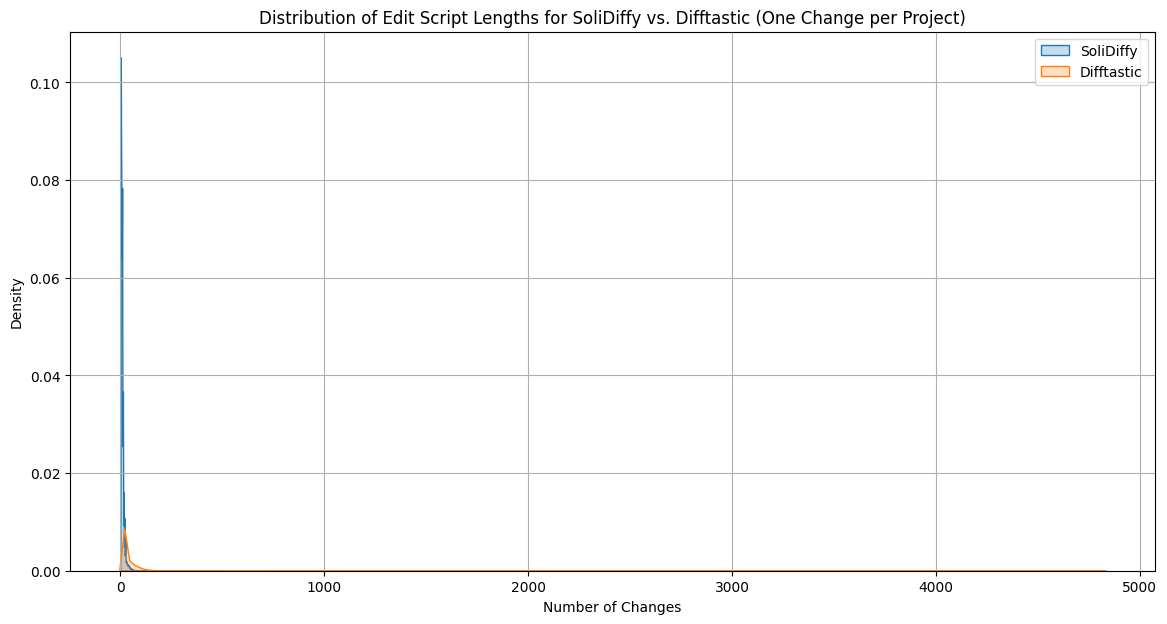

Files with integer content: 330
Files failed to load: 13


In [3]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Define the path to the root directory containing the results
root_dir = '../results/contracts/mutants/'

# Initialize dictionaries to store data by project paths
soliDiffy_data = {}
difftastic_data = {}

file_content_is_int_count = 0
failed_to_load_count = 0

# Batch size for processing files
batch_size = 50000  # Adjust as needed for memory and performance

# Get the list of all files to process
all_files = [(root, file) for root, _, files in os.walk(root_dir) for file in files]

# Process files in batches
for batch_start in range(0, len(all_files), batch_size):
    batch = all_files[batch_start:batch_start + batch_size]
    for root, file in tqdm(batch, desc=f"Processing batch {batch_start // batch_size + 1}"):
        if file == 'diff_result_GT.json' or file == 'diff_result_difft.json':
            file_path = os.path.join(root, file)
            try:
                with open(file_path, 'r') as f:
                    data = json.load(f)
                    if type(data) is int:
                        file_content_is_int_count += 1
                        continue
                    
                    if file == 'diff_result_GT.json':
                        num_changes = data.get('number_of_edits', None)
                    else:
                        num_changes = data.get('number_of_changes', None)
                    

                    if num_changes is not None:
                        key = os.path.dirname(file_path)
                        if file == 'diff_result_GT.json' and key not in soliDiffy_data:
                            soliDiffy_data[key] = num_changes
                        elif file == 'diff_result_difft.json' and key not in difftastic_data:
                            difftastic_data[key] = num_changes
            except json.JSONDecodeError as e:
                print(f"JSON decode error at {file_path}: {e}")
                failed_to_load_count += 1
                continue
            except Exception as e:
                print(f"Unexpected error at {file_path}: {e}")
                failed_to_load_count += 1
                continue

# Align data from both tools into the same DataFrame
common_keys = set(soliDiffy_data.keys()).union(set(difftastic_data.keys()))

# Create lists for SoliDiffy and Difftastic, considering only one change per project
soliDiffy_changes = [soliDiffy_data.get(key, None) for key in common_keys]
difftastic_changes = [difftastic_data.get(key, None) for key in common_keys]

# Create a DataFrame to store the results for plotting
df = pd.DataFrame({
    'SoliDiffy': soliDiffy_changes,
    'Difftastic': difftastic_changes
})



# Calculate the means of each column ignoring NaNs
soliDiffy_mean = df['SoliDiffy'].mean()
difftastic_mean = df['Difftastic'].mean()

missing_soliDiffy = 0
# Replace missing values with the average of the other column using a progress bar
for i in tqdm(range(len(df)), desc="Replacing missing values"):
    if pd.isna(df.loc[i, 'SoliDiffy']):
        missing_soliDiffy += 1
        df.loc[i, 'SoliDiffy'] = soliDiffy_mean
    if pd.isna(df.loc[i, 'Difftastic']):
        df.loc[i, 'Difftastic'] = difftastic_mean
print(f"Replaced {missing_soliDiffy} missing values in SoliDiffy with the solidiffy mean")
# Plotting the distributions over projects
plt.figure(figsize=(14, 7))
sns.kdeplot(df['SoliDiffy'], label='SoliDiffy', fill=True, bw_adjust=0.5)
sns.kdeplot(df['Difftastic'], label='Difftastic', fill=True, bw_adjust=0.5)
plt.title('Distribution of Edit Script Lengths for SoliDiffy vs. Difftastic (One Change per Project)')
plt.xlabel('Number of Changes')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

# Print the counts for files that had issues
print(f"Files with integer content: {file_content_is_int_count}")
print(f"Files failed to load: {failed_to_load_count}")


In [4]:
soliDiffy_mean

np.float64(7.646341535235987)

In [5]:
difftastic_mean

np.float64(18.643368215531506)

Processing batch 1:   9%|▉         | 4458/50000 [00:00<00:02, 22277.16it/s]

JSON decode error at ../results/contracts/mutants/TestUniswapV2Bridge/3/VVR/diff_result_difft.json: Expecting value: line 1 column 1 (char 0)
JSON decode error at ../results/contracts/mutants/SafeERC20HelperUpgradeable/3/BLR/diff_result_difft.json: Expecting value: line 1 column 1 (char 0)
JSON decode error at ../results/contracts/mutants/MakerImportModule/1/BOR/diff_result_difft.json: Expecting value: line 1 column 1 (char 0)


Processing batch 1:  13%|█▎        | 6686/50000 [00:00<00:02, 21191.23it/s]

JSON decode error at ../results/contracts/mutants/StructureNoteFinancialProductLibrary/2/ORFD/diff_result_difft.json: Expecting ',' delimiter: line 908 column 53 (char 32704)
JSON decode error at ../results/contracts/mutants/StandardTokenModified/2/CSC/diff_result_difft.json: Expecting value: line 1 column 1 (char 0)
JSON decode error at ../results/contracts/mutants/TestSTOFactory/2/DLR/diff_result_difft.json: Expecting value: line 1 column 1 (char 0)
JSON decode error at ../results/contracts/mutants/RewardManager/1/MCR/diff_result_difft.json: Expecting value: line 1 column 1 (char 0)
JSON decode error at ../results/contracts/mutants/QValidator/1/DLR/diff_result_difft.json: Expecting value: line 1 column 1 (char 0)
JSON decode error at ../results/contracts/mutants/TwoTokenPoolsBalance/1/MCR/diff_result_difft.json: Expecting value: line 1 column 1 (char 0)
JSON decode error at ../results/contracts/mutants/BEP20Token/1/RSD/diff_result_difft.json: Expecting value: line 1 column 1 (char 0)

Processing batch 1:  21%|██        | 10590/50000 [00:00<00:02, 15180.88it/s]

JSON decode error at ../results/contracts/mutants/SkaleBalances/1/ETR/diff_result_difft.json: Expecting value: line 1 column 1 (char 0)


Processing batch 1:  27%|██▋       | 13585/50000 [00:00<00:02, 12834.75it/s]

JSON decode error at ../results/contracts/mutants/QuickswapStrategyWithdrawMinimizeTrading/1/ORFD/diff_result_difft.json: Expecting ',' delimiter: line 2026 column 26 (char 73610)
JSON decode error at ../results/contracts/mutants/UniProxy/1/EHC/diff_result_difft.json: Expecting value: line 1 column 1 (char 0)


Processing batch 14: 100%|██████████| 25927/25927 [00:02<00:00, 12322.48it/s]


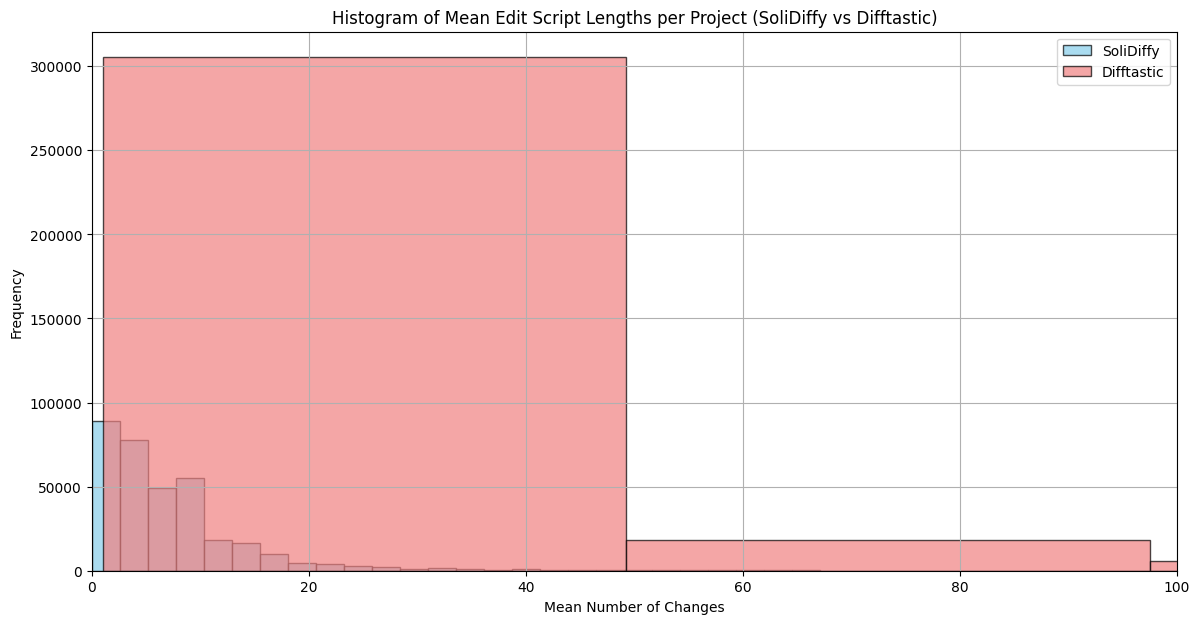

Basic statistics for the mean edit script lengths per project (SoliDiffy):
count    339596.000000
mean          7.646342
std           8.779649
min           0.000000
25%           2.000000
50%           6.000000
75%          10.000000
max         258.000000
Name: SoliDiffy_Mean, dtype: float64

Basic statistics for the mean edit script lengths per project (Difftastic):
count    335988.000000
mean         18.643368
std          55.025178
min           1.000000
25%           2.000000
50%           5.000000
75%          10.000000
max        4826.000000
Name: Difftastic_Mean, dtype: float64

Files with integer content: 330
Files failed to load: 13


In [8]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define the path to the root directory containing the results
root_dir = '../results/contracts/mutants/'

# Initialize dictionaries to store data by project paths
soliDiffy_data = {}
difftastic_data = {}

file_content_is_int_count = 0
failed_to_load_count = 0

# Batch size for processing files
batch_size = 50000  # Adjust as needed for memory and performance

# Get the list of all files to process
all_files = [(root, file) for root, _, files in os.walk(root_dir) for file in files]

# Process files in batches
for batch_start in range(0, len(all_files), batch_size):
    batch = all_files[batch_start:batch_start + batch_size]
    for root, file in tqdm(batch, desc=f"Processing batch {batch_start // batch_size + 1}"):
        if file == 'diff_result_GT.json' or file == 'diff_result_difft.json':
            file_path = os.path.join(root, file)
            try:
                with open(file_path, 'r') as f:
                    data = json.load(f)
                    if type(data) is int:
                        file_content_is_int_count += 1
                        continue
                    
                    # Get the correct key for the number of changes based on file type
                    if file == 'diff_result_GT.json':
                        num_changes = data.get('number_of_edits', None)
                    else:
                        num_changes = data.get('number_of_changes', None)
                    
                    if num_changes is not None:
                        key = os.path.dirname(file_path)
                        if file == 'diff_result_GT.json' and key not in soliDiffy_data:
                            soliDiffy_data[key] = num_changes
                        elif file == 'diff_result_difft.json' and key not in difftastic_data:
                            difftastic_data[key] = num_changes
            except json.JSONDecodeError as e:
                print(f"JSON decode error at {file_path}: {e}")
                failed_to_load_count += 1
                continue
            except Exception as e:
                print(f"Unexpected error at {file_path}: {e}")
                failed_to_load_count += 1
                continue

# Align data from both tools into the same DataFrame
common_keys = set(soliDiffy_data.keys()).union(set(difftastic_data.keys()))

# Create lists for SoliDiffy and Difftastic, considering only one change per project
soliDiffy_changes = [soliDiffy_data.get(key, None) for key in common_keys]
difftastic_changes = [difftastic_data.get(key, None) for key in common_keys]

# Create a DataFrame to store the results
df = pd.DataFrame({
    'SoliDiffy': soliDiffy_changes,
    'Difftastic': difftastic_changes
})

# Calculate the mean edit script length per project for both tools
df['SoliDiffy_Mean'] = df['SoliDiffy']
df['Difftastic_Mean'] = df['Difftastic']

# Set a limit for x-axis to omit the long tail distribution for better discernibility
x_limit = 100  # Adjust this value based on the actual range of your data

# Plot the histograms for both tools
plt.figure(figsize=(14, 7))
plt.hist(df['SoliDiffy_Mean'], bins=100, color='skyblue', edgecolor='black', alpha=0.7, label='SoliDiffy')
plt.hist(df['Difftastic_Mean'], bins=100, color='lightcoral', edgecolor='black', alpha=0.7, label='Difftastic')
plt.title('Histogram of Mean Edit Script Lengths per Project (SoliDiffy vs Difftastic)')
plt.xlabel('Mean Number of Changes')
plt.ylabel('Frequency')
plt.xlim(0, x_limit)  # Omit long tail distribution
plt.legend()
plt.grid(True)
plt.show()

# Print basic statistics for both tools
print("Basic statistics for the mean edit script lengths per project (SoliDiffy):")
print(df['SoliDiffy_Mean'].describe())

print("\nBasic statistics for the mean edit script lengths per project (Difftastic):")
print(df['Difftastic_Mean'].describe())

# Print the counts for files that had issues
print(f"\nFiles with integer content: {file_content_is_int_count}")
print(f"Files failed to load: {failed_to_load_count}")


In [ ]:
df['Difftastic_Mean']

0          4.0
1          6.0
2          2.0
3          6.0
4         22.0
          ... 
341530     5.0
341531    14.0
341532     7.0
341533     1.0
341534    12.0
Name: Difftastic_Mean, Length: 341535, dtype: float64

In [ ]:
df['SoliDiffy_Mean']

0          2.0
1          6.0
2          2.0
3          5.0
4          7.0
          ... 
341530     5.0
341531     1.0
341532     9.0
341533     2.0
341534    12.0
Name: SoliDiffy_Mean, Length: 341535, dtype: float64

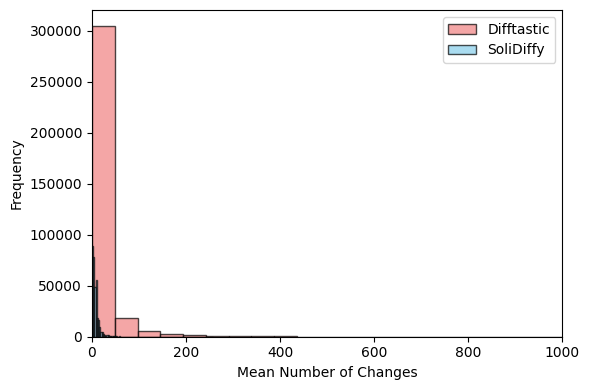

In [11]:
import matplotlib.pyplot as plt

# Define x-axis limit to omit the long tail distribution
x_limit = 1000

# Plot the histograms for both tools, adjusted for ACM paper style
plt.figure(figsize=(6, 4))  # Set figure size to fit into one column
plt.hist(df['Difftastic_Mean'], bins=100, color='lightcoral', edgecolor='black', alpha=0.7, label='Difftastic')
plt.hist(df['SoliDiffy_Mean'], bins=100, color='skyblue', edgecolor='black', alpha=0.7, label='SoliDiffy')

# Increase font sizes for ACM conference paper readability
plt.xlabel('Mean Number of Changes', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.xlim(0, x_limit)  # Limit x-axis to focus on the most relevant range
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10, loc='upper right')
#plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust layout to avoid clipping and improve space usage
plt.tight_layout()

# Display the plot
plt.show()


In [10]:
# Save Difftastic_Mean and SoliDiffy_Mean to CSV files
df['Difftastic_Mean'].to_csv('difftastic_means_.csv', index=False, header=['Difftastic_Mean'])
df['SoliDiffy_Mean'].to_csv('solidiffy_means_.csv', index=False, header=['SoliDiffy_Mean'])

print("Data saved to 'difftastic_mean.csv' and 'solidiffy_mean.csv'")


Data saved to 'difftastic_mean.csv' and 'solidiffy_mean.csv'


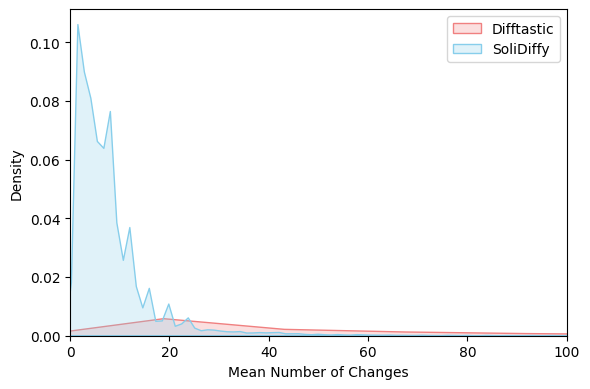

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define x-axis limit to omit the long tail distribution
x_limit = 100

# Set the figure size to fit into one column of an ACM paper
plt.figure(figsize=(6, 4))

# Plot KDE for both SoliDiffy and Difftastic to compare distributions
sns.kdeplot(df['Difftastic_Mean'], label='Difftastic', color='lightcoral', fill=True, bw_adjust=0.5)
sns.kdeplot(df['SoliDiffy_Mean'], label='SoliDiffy', color='skyblue', fill=True, bw_adjust=0.5)

# Increase font sizes for ACM conference paper readability
plt.xlabel('Mean Number of Changes', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.xlim(0, x_limit)  # Limit x-axis to focus on the most relevant range
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10, loc='upper right')
#plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust layout to avoid clipping and improve space usage
plt.tight_layout()

# Display the plot
plt.show()


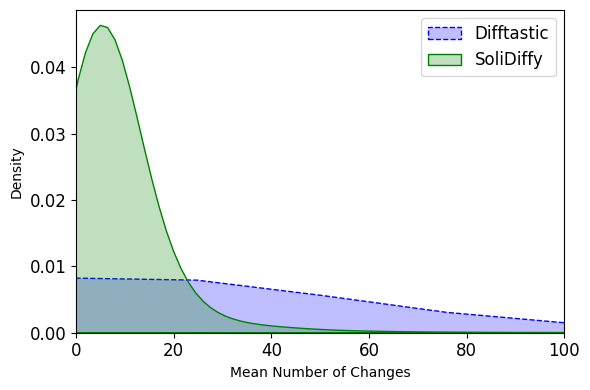

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define x-axis limit to omit the long tail distribution
x_limit = 100

# Set the figure size to fit into one column of an ACM paper
plt.figure(figsize=(6, 4))

# Plot KDE for both SoliDiffy and Difftastic to compare distributions with different line styles
sns.kdeplot(df['Difftastic_Mean'], label='Difftastic', color='#0000ff', linestyle='--', fill=True, bw_adjust=10)
sns.kdeplot(df['SoliDiffy_Mean'], label='SoliDiffy', color='#008000', linestyle='-', fill=True, bw_adjust=10)

# Increase font sizes for ACM conference paper readability
plt.xlabel('Mean Number of Changes', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.xlim(0, x_limit)  # Limit x-axis to focus on the most relevant range
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper right')

# Optionally adjust the y-axis to balance the plot heights
plt.ylim(0, None)  # Allows the plot to auto-adjust, or set a fixed range if needed

# Adjust layout to avoid clipping and improve space usage
plt.tight_layout()

plt.savefig('kde_plot-Mean-Edit-Script-Lengths-per-Project.pdf', format='pdf')
plt.savefig('kde_plot-Mean-Edit-Script-Lengths-per-Project.svg', format='svg')


# Display the plot
plt.show()


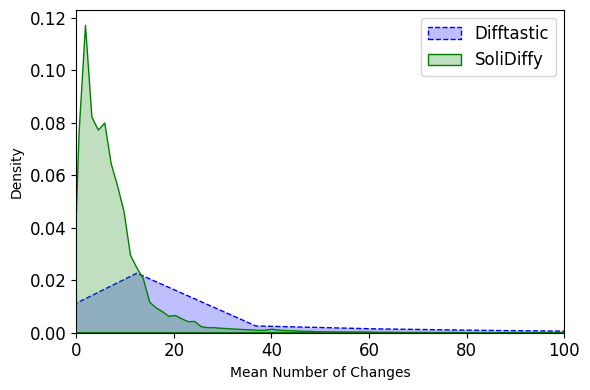

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define x-axis limit to omit the long tail distribution
x_limit = 100

# Set the figure size to fit into one column of an ACM paper
plt.figure(figsize=(6, 4))

# Plot KDE for both SoliDiffy and Difftastic to compare distributions with different line styles
sns.kdeplot(df['Difftastic_Mean'], label='Difftastic', color='#0000ff', linestyle='--', fill=True, bw_adjust=1)
sns.kdeplot(df['SoliDiffy_Mean'], label='SoliDiffy', color='#008000', linestyle='-', fill=True, bw_adjust=1)

# Increase font sizes for ACM conference paper readability
plt.xlabel('Mean Number of Changes', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.xlim(0, x_limit)  # Limit x-axis to focus on the most relevant range
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper right')

# Optionally adjust the y-axis to balance the plot heights
plt.ylim(0, None)  # Allows the plot to auto-adjust, or set a fixed range if needed

# Adjust layout to avoid clipping and improve space usage
plt.tight_layout()

plt.savefig('kde_plot-Mean-Edit-Script-Lengths-per-Project.pdf', format='pdf')
plt.savefig('kde_plot-Mean-Edit-Script-Lengths-per-Project.svg', format='svg')


# Display the plot
plt.show()



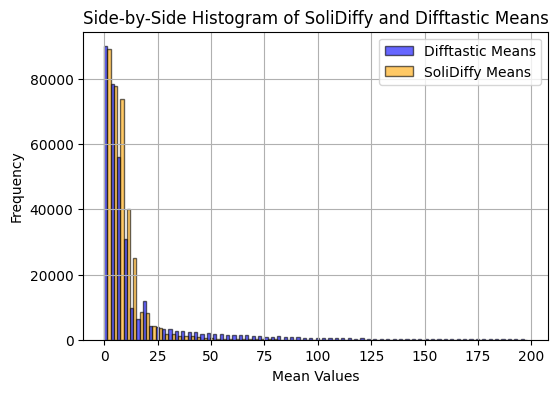

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

solidiffy_means_filled = pd.read_csv('solidiffy_means_filled.csv')
difftastic_means_filled = pd.read_csv('difftastic_means_filled.csv')


# Create side-by-side histograms without overlapping for clear comparison
plt.figure(figsize=(6, 4))

# Define bins for histograms
bins = np.arange(0, 200, 3)  # Static bins from 0 to 500 with a step of 3

# Set bar width to fit side-by-side within each bin
bar_width = 1.5  # Half of bin width to separate the bars

# Get bin counts for both datasets
difftastic_counts, _ = np.histogram(difftastic_means_filled['Difftastic_Mean'], bins=bins)
solidiffy_counts, _ = np.histogram(solidiffy_means_filled['SoliDiffy_Mean'], bins=bins)

# Calculate bin centers for positioning
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot Difftastic Means, adjusted slightly left
plt.bar(bin_centers - bar_width / 2, difftastic_counts, width=bar_width, alpha=0.6, 
        color='blue', edgecolor='black', label='Difftastic Means')

# Plot SoliDiffy Means, adjusted slightly right
plt.bar(bin_centers + bar_width / 2, solidiffy_counts, width=bar_width, alpha=0.6, 
        color='orange', edgecolor='black', label='SoliDiffy Means')

# Customize plot
plt.title('Side-by-Side Histogram of SoliDiffy and Difftastic Means')
plt.xlabel('Mean Values')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


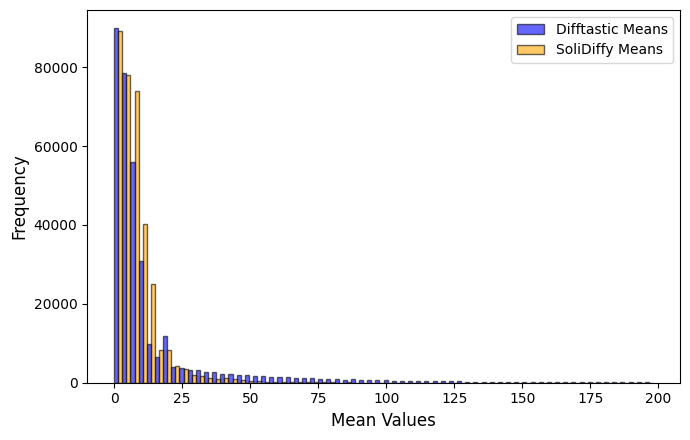

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
solidiffy_means_filled = pd.read_csv('solidiffy_means_filled.csv')
difftastic_means_filled = pd.read_csv('difftastic_means_filled.csv')

# Set figure size suitable for double-column ACM paper
plt.figure(figsize=(7, 4.5))

# Define bins for histograms
bins = np.arange(0, 200, 3)  # Adjusted bins range

# Set bar width to fit side-by-side within each bin
bar_width = 1.5

# Get bin counts for both datasets
difftastic_counts, _ = np.histogram(difftastic_means_filled['Difftastic_Mean'], bins=bins)
solidiffy_counts, _ = np.histogram(solidiffy_means_filled['SoliDiffy_Mean'], bins=bins)

# Calculate bin centers for positioning
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot Difftastic Means, adjusted slightly left
plt.bar(bin_centers - bar_width / 2, difftastic_counts, width=bar_width, alpha=0.6, 
        color='blue', edgecolor='black', label='Difftastic Means')

# Plot SoliDiffy Means, adjusted slightly right
plt.bar(bin_centers + bar_width / 2, solidiffy_counts, width=bar_width, alpha=0.6, 
        color='orange', edgecolor='black', label='SoliDiffy Means')

# Customize plot
plt.xlabel('Mean Values', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10, loc='upper right')
plt.grid(False)

# Adjust layout to use space efficiently
plt.tight_layout()

# Display the plot
plt.show()


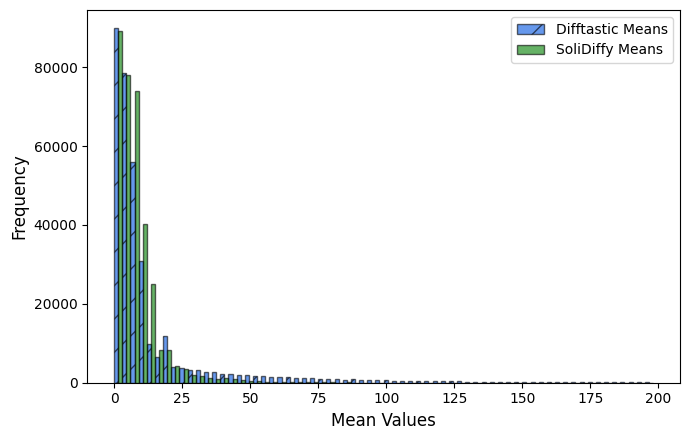

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
solidiffy_means_filled = pd.read_csv('solidiffy_means_filled.csv')
difftastic_means_filled = pd.read_csv('difftastic_means_filled.csv')

# Set figure size suitable for double-column ACM paper
plt.figure(figsize=(7, 4.5))

# Define bins for histograms
bins = np.arange(0, 200, 3)  # Adjusted bins range

# Set bar width to fit side-by-side within each bin
bar_width = 1.5

# Get bin counts for both datasets
difftastic_counts, _ = np.histogram(difftastic_means_filled['Difftastic_Mean'], bins=bins)
solidiffy_counts, _ = np.histogram(solidiffy_means_filled['SoliDiffy_Mean'], bins=bins)

# Calculate bin centers for positioning
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot Difftastic Means, adjusted slightly left with a pattern
plt.bar(bin_centers - bar_width / 2, difftastic_counts, width=bar_width, alpha=0.6, 
        color='#0053e0', edgecolor='black', label='Difftastic Means', hatch='/')

# Plot SoliDiffy Means, adjusted slightly right
plt.bar(bin_centers + bar_width / 2, solidiffy_counts, width=bar_width, alpha=0.6, 
        color='#008000', edgecolor='black', label='SoliDiffy Means')

# Customize plot

plt.xlabel('Mean Values', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10, loc='upper right')
plt.grid(False)

# Adjust layout to use space efficiently
plt.tight_layout()

# Display the plot
plt.show()


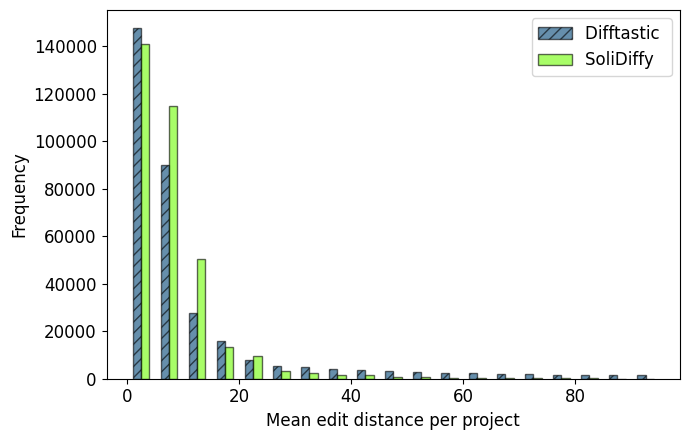

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
solidiffy_means_filled = pd.read_csv('solidiffy_means_filled.csv')
difftastic_means_filled = pd.read_csv('difftastic_means_filled.csv')

# Set figure size suitable for double-column ACM paper
plt.figure(figsize=(7, 4.5))

# Define bins for histograms
bins = np.arange(0, 100, 5)  # Adjusted bins range

# Set bar width to fit side-by-side within each bin
bar_width = 1.5

# Get bin counts for both datasets
difftastic_counts, _ = np.histogram(difftastic_means_filled['Difftastic_Mean'], bins=bins)
solidiffy_counts, _ = np.histogram(solidiffy_means_filled['SoliDiffy_Mean'], bins=bins)

# Calculate bin centers for positioning
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot Difftastic Means, adjusted slightly left with a pattern
plt.bar(bin_centers - bar_width / 2, difftastic_counts, width=bar_width, alpha=0.6, 
        color='#004475', edgecolor='black', label='Difftastic ', hatch='///')

# Plot SoliDiffy Means, adjusted slightly right
plt.bar(bin_centers + bar_width / 2, solidiffy_counts, width=bar_width, alpha=0.6, 
        color='#6ffc03', edgecolor='black', label='SoliDiffy ')
# Customize plot

plt.xlabel('Mean edit distance per project', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper right')
plt.grid(False)

plt.savefig('histogram-Mean-Edit-Script-Lengths-per-Project.pdf', format='pdf')

# Adjust layout to use space efficiently
plt.tight_layout()

# Display the plot
plt.show()


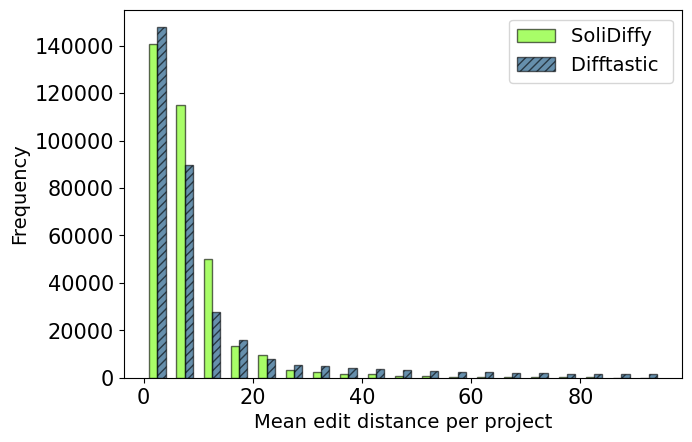

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
solidiffy_means_filled = pd.read_csv('solidiffy_means_filled.csv')
difftastic_means_filled = pd.read_csv('difftastic_means_filled.csv')

# Set figure size suitable for double-column ACM paper
plt.figure(figsize=(7, 4.5))

# Define bins for histograms
bins = np.arange(0, 100, 5)  # Adjusted bins range

# Set bar width to fit side-by-side within each bin
bar_width = 1.5

# Get bin counts for both datasets
difftastic_counts, _ = np.histogram(difftastic_means_filled['Difftastic_Mean'], bins=bins)
solidiffy_counts, _ = np.histogram(solidiffy_means_filled['SoliDiffy_Mean'], bins=bins)

# Calculate bin centers for positioning
bin_centers = (bins[:-1] + bins[1:]) / 2

# # Plot SoliDiffy Means, adjusted slightly right
# plt.bar(bin_centers + bar_width / 2, solidiffy_counts, width=bar_width, alpha=0.6, 
#         color='#6ffc03', edgecolor='black', label='SoliDiffy ')


# # Plot Difftastic Means, adjusted slightly left with a pattern
# plt.bar(bin_centers - bar_width / 2, difftastic_counts, width=bar_width, alpha=0.6, 
#         color='#004475', edgecolor='black', label='Difftastic ', hatch='////')



# Plot SoliDiffy Means, adjusted slightly right
plt.bar(bin_centers - bar_width / 2, solidiffy_counts, width=bar_width, alpha=0.6, 
        color='#6ffc03', edgecolor='black', label='SoliDiffy ')


# Plot Difftastic Means, adjusted slightly left with a pattern
plt.bar(bin_centers + bar_width / 2, difftastic_counts, width=bar_width, alpha=0.6, 
        color='#004475', edgecolor='black', label='Difftastic ', hatch='////')


plt.xlabel('Mean edit distance per project', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=14, loc='upper right')
plt.grid(False)
plt.subplots_adjust(left=0.17, right=0.99, top=0.99, bottom=0.12)

plt.savefig('histogram-Mean-Edit-Script-Lengths-per-Project.pdf', format='pdf')

# Adjust layout to use space efficiently
plt.tight_layout(pad=1.0)


# Display the plot
plt.show()
